In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gym
import random
import itertools
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from IPython.display import clear_output

#dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
print(tf.__version__)
env = gym.make('CartPole-v0')

2.2.0


In [2]:
#Cartpole Specific Model
def create_cartmodel(input_shape, no_of_actions, lr):
    model = tf.keras.Sequential([
        Dense(24, input_shape = (input_shape, ), activation = "relu", kernel_initializer= "he_uniform"),
        Dense(24, activation = "relu", kernel_initializer= "he_uniform"),
        Dense(no_of_actions, activation = "linear", kernel_initializer= "he_uniform")
    ])
    model.compile(optimizer = Adam(lr = lr), loss = 'mse')
    return model

In [3]:
class DQL:

    def __init__(self, env, model, epsilon = 1, decay_rate = 0.996, min_epsilon = 0.1, discount_factor = 0.95, name = 'Default'):
        """
        Function which initializes all the values and parameters for the Deep Q Learning

        Input:
        env - Open AI Environment
        model - Q learning model specific to the environment
        epsilon - The rate of being greedy (Default = 1)
        decay_rate - Epsilon decay rate (Default = 0.99)
        min_epsilon - Minimum value of epsilon (Default = 0.1)
        discount_factor - Gamma value for RL (Default = 1)
        name - Model's Name (Default = 'Default)

        Returns:
        DQL Object
        """
        self.name = name
        self.env = env
        self.model = model
        self.epsilon = epsilon
        self.decay_rate = decay_rate
        self.discount_factor = discount_factor
        self.min_epsilon = min_epsilon
        self.er = []
        self.rewards = []
        self.mse = []
        self.batch_size = 0

    def predict(self, state):
        return self.model.predict(state.reshape(1, -1))

    def epsilon_policy(self, state):
        '''
        Function which finds the action probabilities based on epsilon policy given a specific state

        Input:
        state - The current state of the environment

        Returns:
        Probabilities of all the actions
        ''' 

        if random.random() <= self.epsilon:
            return random.randrange(self.env.action_space.n)
        
        else:
            return np.argmax(self.predict(state)[0])

    def plot(self, i, tot_reward, tot_loss):
        clear_output(wait = True)
        fig, ax = plt.subplots(1, 2, figsize = (12, 5))
        fig.suptitle("Episode : {} Reward: {} Loss: {} Epsilon: {}".format(i, tot_reward, round(tot_loss, 3), round(self.epsilon, 3)))
        ax[0].set_xlabel('Episodes')
        ax[0].set_ylabel('Rewards')
        ax[1].set_xlabel('Episodes')
        ax[1].set_ylabel('MSE')
        ax[1].plot(self.mse)
        ax[0].plot(self.rewards)
        ax[0].grid()
        ax[1].grid()
        plt.show()

    def prepopulate_er(self):
        state = self.env.reset()
        for i in range(self.batch_size):

            action = self.epsilon_policy(state)
            next_state, reward, done, _ = self.env.step(action)
            self.er.append((state, action, reward, next_state, done))

            if done:
                state = self.env.reset()
            
            else:
                state = next_state

    
    def update_network(self):

        samples = random.sample(self.er, self.batch_size)
        States = np.array([s[0] for s in samples])
        Next_States = np.array([s[3] for s in samples])
        
        target = self.model.predict(States)
        target_next = self.model.predict(Next_States)

        for j,s in enumerate(samples):
            state, action, reward, next_state, done = s
            if done:
                target[j][action] = reward
            else:
                target[j][action] = reward + (self.discount_factor * np.amax(target_next[j]))
        
        hist = self.model.fit(States, target, batch_size = self.batch_size, verbose = False)
        return round(hist.history['loss'][0], 3)

    def learn(self, noe, batch_size):
        
        self.batch_size = batch_size
        self.prepopulate_er()

        for i in range(noe):
            tot_reward = 0
            tot_loss = 0
            length = 0
            self.epsilon = (max(self.min_epsilon, self.epsilon*self.decay_rate))
            state = self.env.reset()
            while True:
                self.env.render()
                action = self.epsilon_policy(state)
                '''
                if(action == 0): 
                    print("L", end = ' ') 
                else: 
                    print("R", end = ' ')
                '''
                next_state, reward, done, _ = self.env.step(action)

                self.er.append((state, action, reward, next_state, done))
                loss = self.update_network()
                length += 1
                tot_reward += reward
                tot_loss += loss if loss else 0
                if done:
                    break
                else:
                    state = next_state

            #if(i % 10 == 0):
            print()
            tot_loss/=length
            self.rewards.append(tot_reward)
            self.mse.append(tot_loss)
            self.plot(i, tot_reward, tot_loss)
            #print("Episode : {} Reward: {} Loss: {} Epsilon: {}".format(i, tot_reward, tot_loss, round(self.epsilon, 3)))


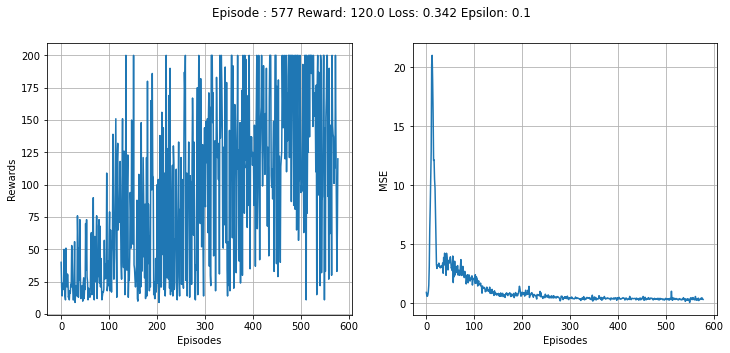

KeyboardInterrupt: 

In [4]:
model = create_cartmodel(4, 2, 0.001)
dql = DQL(env, model)
dql.learn(1000, 64)
env.close()

In [5]:
env.close()

In [32]:
lst = [1,2,3,4,5]
for j,s in enumerate(lst):
    print(j,s)

0 1
1 2
2 3
3 4
4 5
